## Libraries to import

In [1]:
!pip install tensorflow
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

Mounted at /content/drive


## Importing the dataset

In [3]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_1h.csv')

### Feature engineering

In [4]:
# adding features that make more sense than raw data
# all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
# all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
# all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

# all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
# all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
# all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

In [5]:
all_prices = all_prices.dropna().drop(columns=['Datetime'])

In [6]:
all_prices.head()

,Gold,Silver,CAD
0,2136.500000,26.150000,0.740730
1,2115.600098,26.059999,0.740730
2,2107.699951,25.915001,0.740466
3,2108.199951,25.940001,0.740297
4,2105.500000,25.870001,0.739809


In [7]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12511 entries, 0 to 12510
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gold    12511 non-null  float64
 1   Silver  12511 non-null  float64
 2   CAD     12511 non-null  float64
dtypes: float64(3)
memory usage: 293.4 KB


In [8]:
all_prices.describe()

,Gold,Silver,CAD
count,12511.000000,12511.000000,12511.000000
mean,2836.940654,32.635758,0.723850
std,602.589997,7.054973,0.015195
min,1989.300049,22.014999,0.676535
25%,2357.750000,28.600000,0.714344
50%,2678.500000,31.415001,0.726533
75%,3337.650024,34.802500,0.735078
max,4394.299805,58.564999,0.758392


In [9]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)
scaled

array([[0.06120581, 0.1131327 , 0.78423446],
       [0.05251562, 0.11067032, 0.78423446],
       [0.04923073, 0.10670319, 0.78101817],
       ...,
       [0.95155925, 0.98837211, 0.47929403],
       [0.94989604, 0.98317379, 0.47929403],
       [0.95268199, 0.98180582, 0.47929403]])

In [10]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [11]:
max_window = 60

X, y = create_sequences(scaled, max_window)
X.shape

(12451, 60, 3)

### Train/test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

## GRU implementation

### Hyperparameter tuning

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [ ]:
def model_builder(hp):
    model = keras.Sequential([
        keras.layers.SimpleRNN(
            units=hp.Int("units_1", min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(hp.Int("window", min_value=10, max_value=100, step=10), 3),
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg", values=[1e-6, 1e-5, 1e-4]))
        ),
        keras.layers.Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.SimpleRNN(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg2", [1e-6, 1e-5, 1e-4])),
        ),
        keras.layers.Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.Dense(3, activation="relu") #output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),\
        loss="mse",
        metrics=[rmse, mae, mape]
    )

    return model

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_rmse", direction="min"),
    max_epochs=40,
    max_consecutive_failed_trials=5,
    seed=42,
    directory="tuning_results",
    project_name="gold_silver_cad",
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [ ]:
tuner.search(x=X_train, y=y_train, validation_split=0.15, callbacks=[stop_early])

Trial 90 Complete [00h 01m 02s]
val_rmse: 0.02494841068983078

Best val_rmse So Far: 0.006615498103201389
Total elapsed time: 01h 04m 09s


### Metrics evaluation of the best model

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_model.save('rnn_1h.keras')
best_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 70, 48)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 70, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 56)             │         5,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           171 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,547 (33.39 KB)

 Trainable params: 8,547 (33.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units_1': 48,
 'window': 70,
 'l2_reg': 0.0001,
 'dropout_1': 0.1,
 'units_2': 56,
 'l2_reg2': 1e-06,
 'dropout_2': 0.1,
 'learning_rate': 0.0005,
 'tuner/epochs': 40,
 'tuner/initial_epoch': 14,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0048'}

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model = best_model

y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("MAPE:", mape_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 42.26949925499731
MAE : 21.389735332339853
MAPE: 0.010884098622039822


In [ ]:
baseline = scaler.inverse_transform(X_test[:, -1, :])

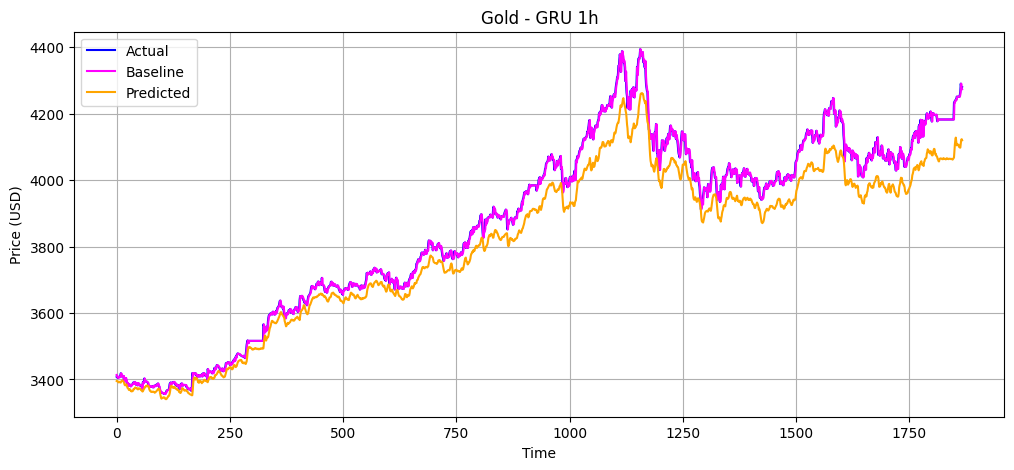

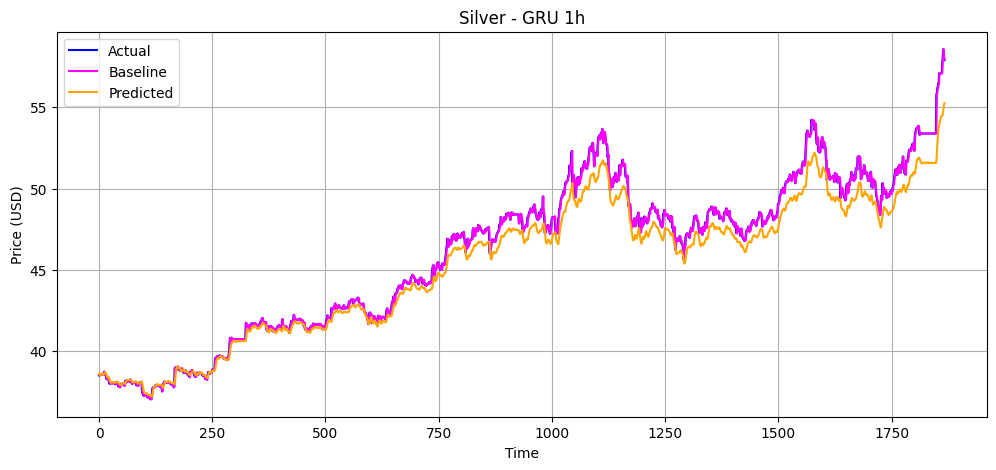

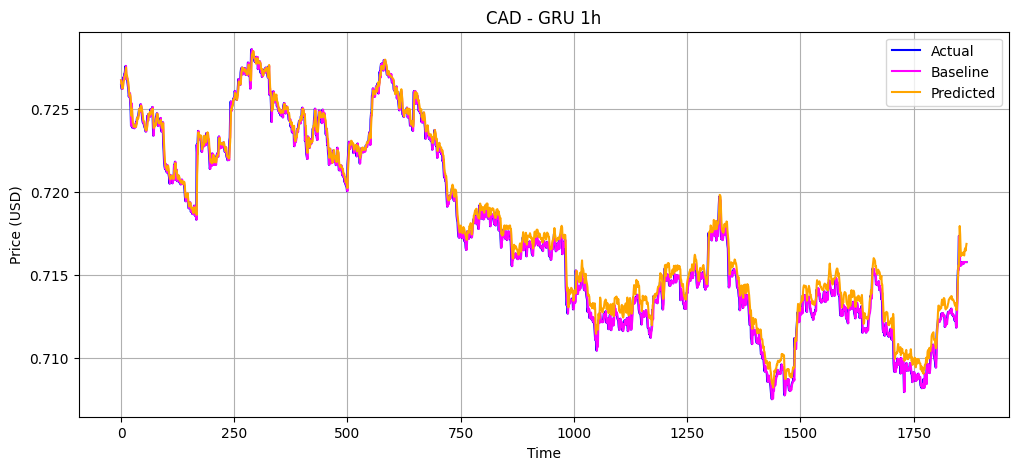

In [ ]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.title(f"{asset_name} - GRU 1h")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [ ]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

Gold
 MAE : 63.380033374598504
 RMSE: 73.20602446119398
 MAPE: 1.583900798264165

Silver
 MAE : 0.78863682838783
 RMSE: 1.0048303025062773
 MAPE: 1.6064403931609275

CAD
 MAE : 0.0005357940332282028
 RMSE: 0.0006744537022341952
 MAPE: 0.07488839518685439



### Mean + std

To ensure the model did not randomly achieve good results with the test set

In [13]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [ ]:
# {'units_1': 48,
#  'window': 70,
#  'l2_reg': 0.0001,
#  'dropout_1': 0.1,
#  'units_2': 56,
#  'l2_reg2': 1e-06,
#  'dropout_2': 0.1,
#  'learning_rate': 0.0005,
#  'tuner/epochs': 40,
#  'tuner/initial_epoch': 14,
#  'tuner/bracket': 3,
#  'tuner/round': 3,
#  'tuner/trial_id': '0048'}

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mae_arr = []
rmse_arr = []
mape_arr = []

for i in range(10):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

  model = keras.Sequential([
      keras.layers.SimpleRNN(
          units=48,
          return_sequences=True,
          input_shape=(70, 3),
          kernel_regularizer=keras.regularizers.l2(0.0001)
      ),
      keras.layers.Dropout(0.1),
      keras.layers.SimpleRNN(
          units=56,
          return_sequences=False,
          kernel_regularizer=keras.regularizers.l2(1e-06),
      ),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(3, activation="relu") #output
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(0.0005),
      loss='mse',
      metrics=[rmse, mae, mape]
  )

  model.fit(X_train, y_train, epochs=40)

  y_pred = model.predict(X_test)

  y_pred_inv = scaler.inverse_transform(y_pred)
  y_test_inv = scaler.inverse_transform(y_test)

  rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
  mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
  mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

  rmse_arr.append(rmse_val)
  mae_arr.append(mae_val)
  mape_arr.append(mape_val)

  print("RMSE:", rmse_val)
  print("MAE :", mae_val)
  print("MAPE:", mape_val)

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0480 - mae: 0.1645 - mape: 8332.4326 - rmse: 0.2051
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0073 - mae: 0.0634 - mape: 3750.5020 - rmse: 0.0814
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0040 - mae: 0.0456 - mape: 35659.5273 - rmse: 0.0583
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0029 - mae: 0.0379 - mape: 1604.9862 - rmse: 0.0486
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0023 - mae: 0.0328 - mape: 1762.0471 - rmse: 0.0425
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0020 - mae: 0.0297 - mape: 24063.6094 - rmse: 0.0384
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 0.0017 - mae: 0.0274 - mape: 4711.7368 - rmse: 0.0355
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0015 - mae: 0.0249 - mape: 30572.2246 - rmse: 0.0324
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0014 - mae: 0.0236

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0666 - mae: 0.1967 - mape: 155851.9531 - rmse: 0.2431
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0065 - mae: 0.0599 - mape: 30481.7246 - rmse: 0.0769
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0035 - mae: 0.0427 - mape: 14882.9033 - rmse: 0.0545
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0026 - mae: 0.0357 - mape: 5623.3862 - rmse: 0.0456
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0021 - mae: 0.0312 - mape: 9588.6025 - rmse: 0.0400
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0017 - mae: 0.0278 - mape: 82006.8984 - rmse: 0.0358
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0016 - mae: 0.0259 - mape: 13831.9844 - rmse: 0.0336
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0014 - mae: 0.0238 - mape: 21188.3457 - rmse: 0.0310
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0013 - mae: 0.0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0328 - mae: 0.1320 - mape: 57.4370 - rmse: 0.1671
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0057 - mae: 0.0559 - mape: 11536.5205 - rmse: 0.0713
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0036 - mae: 0.0429 - mape: 30643.6445 - rmse: 0.0551
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0027 - mae: 0.0366 - mape: 8420.9893 - rmse: 0.0471
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0022 - mae: 0.0317 - mape: 3929.7400 - rmse: 0.0411
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0018 - mae: 0.0286 - mape: 31905.6426 - rmse: 0.0370
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0016 - mae: 0.0261 - mape: 31366.3086 - rmse: 0.0340
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0014 - mae: 0.0239 - mape: 8754.1201 - rmse: 0.0312
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0012 - mae: 0.0220 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.0560 - mae: 0.1776 - mape: 208873.6406 - rmse: 0.2209
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0082 - mae: 0.0680 - mape: 8938.7676 - rmse: 0.0869
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0044 - mae: 0.0481 - mape: 87536.3750 - rmse: 0.0618
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0031 - mae: 0.0395 - mape: 30676.1074 - rmse: 0.0506
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0025 - mae: 0.0347 - mape: 88079.7734 - rmse: 0.0444
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0021 - mae: 0.0310 - mape: 71973.8984 - rmse: 0.0399
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.0018 - mae: 0.0282 - mape: 13118.6182 - rmse: 0.0364
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0016 - mae: 0.0259 - mape: 61133.4141 - rmse: 0.0332
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.0014 - mae: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0628 - mae: 0.1887 - mape: 26950.2949 - rmse: 0.2319
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0073 - mae: 0.0641 - mape: 35.8210 - rmse: 0.0820
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0039 - mae: 0.0449 - mape: 1630.3640 - rmse: 0.0578
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - loss: 0.0029 - mae: 0.0377 - mape: 24.6936 - rmse: 0.0488
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0023 - mae: 0.0328 - mape: 6240.6152 - rmse: 0.0424
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0020 - mae: 0.0299 - mape: 12378.9854 - rmse: 0.0386
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.0017 - mae: 0.0273 - mape: 22339.3730 - rmse: 0.0354
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0015 - mae: 0.0251 - mape: 6119.7139 - rmse: 0.0324
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0013 - mae: 0.0235 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 0.0538 - mae: 0.1755 - mape: 2776.3989 - rmse: 0.2174
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0072 - mae: 0.0634 - mape: 48124.7031 - rmse: 0.0810
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0041 - mae: 0.0468 - mape: 25253.3789 - rmse: 0.0598
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0030 - mae: 0.0384 - mape: 31717.3496 - rmse: 0.0492
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 0.0024 - mae: 0.0336 - mape: 7118.7363 - rmse: 0.0430
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0020 - mae: 0.0301 - mape: 2156.7871 - rmse: 0.0388
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0017 - mae: 0.0269 - mape: 12917.9043 - rmse: 0.0347
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0015 - mae: 0.0250 - mape: 28393.9941 - rmse: 0.0324
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0014 - mae: 0.0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 0.0541 - mae: 0.1706 - mape: 153724.2812 - rmse: 0.2122
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - loss: 0.0072 - mae: 0.0636 - mape: 170425.1719 - rmse: 0.0810
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0042 - mae: 0.0467 - mape: 14280.6738 - rmse: 0.0598
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0030 - mae: 0.0393 - mape: 24609.0898 - rmse: 0.0500
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0025 - mae: 0.0340 - mape: 41288.2812 - rmse: 0.0440
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0021 - mae: 0.0309 - mape: 5130.2705 - rmse: 0.0397
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0018 - mae: 0.0285 - mape: 69733.3281 - rmse: 0.0367
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0016 - mae: 0.0259 - mape: 43080.2969 - rmse: 0.0336
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0015 - mae:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0488 - mae: 0.1670 - mape: 968.7675 - rmse: 0.2045
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0065 - mae: 0.0599 - mape: 27280.4512 - rmse: 0.0763
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0038 - mae: 0.0443 - mape: 21220.1035 - rmse: 0.0568
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0028 - mae: 0.0367 - mape: 6190.0220 - rmse: 0.0470
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0022 - mae: 0.0318 - mape: 18029.2598 - rmse: 0.0410
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0019 - mae: 0.0285 - mape: 55812.1406 - rmse: 0.0368
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0017 - mae: 0.0263 - mape: 24537.2734 - rmse: 0.0341
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0014 - mae: 0.0237 - mape: 7291.2275 - rmse: 0.0309
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0013 - mae: 0.022

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0437 - mae: 0.1552 - mape: 4859.2300 - rmse: 0.1930
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0060 - mae: 0.0573 - mape: 2549.1855 - rmse: 0.0734
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0036 - mae: 0.0432 - mape: 75553.9062 - rmse: 0.0554
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0025 - mae: 0.0351 - mape: 17025.8027 - rmse: 0.0452
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0021 - mae: 0.0311 - mape: 42504.3555 - rmse: 0.0400
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0018 - mae: 0.0280 - mape: 44003.4375 - rmse: 0.0362
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0015 - mae: 0.0251 - mape: 41876.4570 - rmse: 0.0328
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0014 - mae: 0.0232 - mape: 17282.4023 - rmse: 0.0304
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0012 - mae: 0.02

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 0.0410 - mae: 0.1543 - mape: 69.5445 - rmse: 0.1911
Epoch 2/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0071 - mae: 0.0630 - mape: 2127.1685 - rmse: 0.0804
Epoch 3/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0040 - mae: 0.0458 - mape: 45881.1719 - rmse: 0.0586
Epoch 4/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0030 - mae: 0.0384 - mape: 23.5063 - rmse: 0.0493
Epoch 5/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0024 - mae: 0.0337 - mape: 11055.2236 - rmse: 0.0434
Epoch 6/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0019 - mae: 0.0296 - mape: 17004.4180 - rmse: 0.0381
Epoch 7/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0017 - mae: 0.0270 - mape: 76196.8828 - rmse: 0.0349
Epoch 8/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0015 - mae: 0.0245 - mape: 7806.5869 - rmse: 0.0318
Epoch 9/40
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0013 - mae: 0.0230 - m

In [ ]:
mae_arr = np.array(mae_arr)
rmse_arr = np.array(rmse_arr)
mape_arr = np.array(mape_arr)

print("RMSE: mean =", np.mean(rmse_arr), '|| std dev =', np.std(rmse_arr))
print("MAE : mean =", np.mean(mae_arr), '|| std dev =', np.std(mae_arr))
print("MAPE: mean =", np.mean(mape_arr), '|| std dev =', np.std(mape_arr))

RMSE: mean = 20.78361624276031 || std dev = 7.957859072971383
MAE : mean = 10.29797380026071 || std dev = 4.256167323320711
MAPE: mean = 0.006573508117572509 || std dev = 0.0020245701503726165


### Final model

Model trained on all the dataset set to be used for future predictions

In [14]:
model = keras.Sequential([
    keras.layers.SimpleRNN(
        units=48,
        return_sequences=True,
        input_shape=(70, 3),
        kernel_regularizer=keras.regularizers.l2(0.0001)
    ),
    keras.layers.Dropout(0.1),
    keras.layers.SimpleRNN(
        units=56,
        return_sequences=False,
        kernel_regularizer=keras.regularizers.l2(1e-06),
    ),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(3, activation="relu") #output
])

model.compile(
    optimizer=keras.optimizers.Adam(0.0005),
    loss='mse',
    metrics=[rmse, mae, mape]
)

model.fit(X, y, epochs=40)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0535 - mae: 0.1671 - mape: 8151.9150 - rmse: 0.2106
Epoch 2/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 0.0058 - mae: 0.0560 - mape: 28006.4102 - rmse: 0.0722
Epoch 3/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0034 - mae: 0.0414 - mape: 767.5698 - rmse: 0.0538
Epoch 4/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 0.0025 - mae: 0.0348 - mape: 1852.7056 - rmse: 0.0448
Epoch 5/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.0021 - mae: 0.0311 - mape: 31835.7930 - rmse: 0.0405
Epoch 6/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0018 - mae: 0.0279 - mape: 21597.2969 - rmse: 0.0366
Epoch 7/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0016 - mae: 0.0259 - mape: 2179.6553 - rmse: 0.0342
Epoch 8/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0014 - mae: 0.0241 - mape: 12960.3535 - rmse: 0.0318
Epoch 9/40
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0013 

In [15]:
model.save('rnn_1h.keras')